# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from ie590.classifiers.fc_net import *
from ie590.data_utils import get_CIFAR10_data
from ie590.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ie590.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `ie590/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [3]:
np.random.seed(220)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000073983317677
Mean of train-time output:  9.98080292226031
Mean of test-time output:  10.000073983317677
Fraction of train-time output set to zero:  0.750536
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000073983317677
Mean of train-time output:  10.010557654593667
Mean of test-time output:  10.000073983317677
Fraction of train-time output set to zero:  0.599512
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000073983317677
Mean of train-time output:  9.998440656659579
Mean of test-time output:  10.000073983317677
Fraction of train-time output set to zero:  0.30004
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `ie590/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [4]:
np.random.seed(220)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8928991957763582e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
We will be considering only the summation of all possible sub-networks which may lead to exploding gradients. This happens because at test time we require an approximation of the expected output produced by the training phase, due to we only perform a forward call without dropping neurons out.


# Fully-connected nets with Dropout
In the file `ie590/classifiers/fc_net.py`, modify your implementation to use dropout. Specifically, if the constructor of the network receives a value that is not 1 for the `dropout` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity. After doing so, run the following to numerically gradient-check your implementation.

In [5]:
np.random.seed(220)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-3 or less; Note that it's fine
 
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3109271789130945
W1 relative error: 1.84e-05
W2 relative error: 1.59e-03
W3 relative error: 1.72e-06
b1 relative error: 4.36e-07
b2 relative error: 1.66e-07
b3 relative error: 8.72e-11

Running check with dropout =  0.75
Initial loss:  2.302196875425341
W1 relative error: 1.11e-06
W2 relative error: 1.49e-03
W3 relative error: 1.35e-06
b1 relative error: 1.21e-07
b2 relative error: 6.74e-07
b3 relative error: 1.06e-10

Running check with dropout =  0.5
Initial loss:  2.3003797096332903
W1 relative error: 1.45e-04
W2 relative error: 1.02e-03
W3 relative error: 3.49e-06
b1 relative error: 9.15e-07
b2 relative error: 2.86e-07
b3 relative error: 8.60e-11



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.3. We will then visualize the training and validation accuracies of the two networks over time.

In [6]:
# Train two identical nets, one with dropout and one without
np.random.seed(220)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.3]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

1
(Iteration 1 / 125) loss: 8.304421
(Epoch 0 / 25) train acc: 0.192000; val_acc: 0.195000
(Epoch 1 / 25) train acc: 0.388000; val_acc: 0.228000
(Epoch 2 / 25) train acc: 0.480000; val_acc: 0.249000
(Epoch 3 / 25) train acc: 0.584000; val_acc: 0.273000
(Epoch 4 / 25) train acc: 0.716000; val_acc: 0.285000
(Epoch 5 / 25) train acc: 0.796000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.834000; val_acc: 0.265000
(Epoch 7 / 25) train acc: 0.818000; val_acc: 0.262000
(Epoch 8 / 25) train acc: 0.868000; val_acc: 0.259000
(Epoch 9 / 25) train acc: 0.914000; val_acc: 0.268000
(Epoch 10 / 25) train acc: 0.950000; val_acc: 0.251000
(Epoch 11 / 25) train acc: 0.958000; val_acc: 0.259000
(Epoch 12 / 25) train acc: 0.940000; val_acc: 0.281000
(Epoch 13 / 25) train acc: 0.968000; val_acc: 0.283000
(Epoch 14 / 25) train acc: 0.928000; val_acc: 0.279000
(Epoch 15 / 25) train acc: 0.944000; val_acc: 0.263000
(Epoch 16 / 25) train acc: 0.952000; val_acc: 0.280000
(Epoch 17 / 25) train acc: 0.934000; v

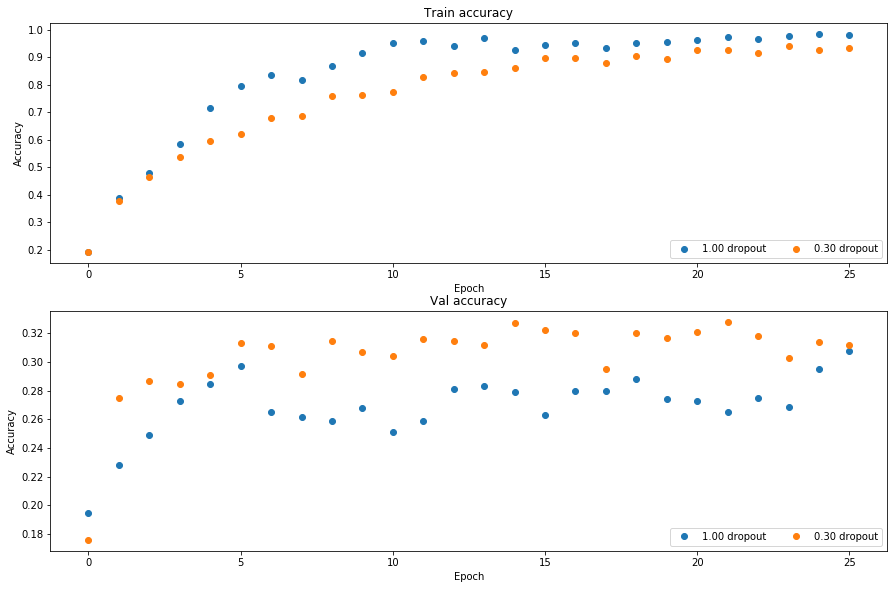

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
We are overfitting the model. In the training phase, when we do not use dropout the accuracies are very high ; however, with dropout the accuracies are smaller. This suggests that with dropout we are learning a simpler model and therefore we are trying to avoid overfitting. In the validation phase, we can see that with dropout we obtained slighly better results. This suggest that effectively with dropout we are regularizing our model and we are reducing overfitting. 


## Inline Question 3:
Should we use dropout in the input layer? Why / Why not?

## Answer:
If Dropout is applied to the input, each sample results in dropping out random values which does not help during training. If the values were discarded in a systematic way (such as dimensionality reduction using PCA or sparsity using the greatest values in each sample), the CNN may generalize better but randomly dropping out data values does not help aliviate overfitting 


## Inline Question 4:
Do the weights of the network change when trained using dropout as compared to not using dropout? If they change, do they increase or decrease as compared to not using dropout?

## Answer:
When learning large networks without dropout the problem of co-adaptation which means some neurons will have more predictive capability than the others. Over a period of training time, weaker ones are ignored. This is the reason why dropouts are used in networks.

we scale the weights using the dropout P so that it becomes computationally inexpensive when calulating loss and this loss is equivalent to the loss without dropout.


## Inline Question 5:
Should we use dropout while testing? Why/Why not?

## Answer:
We should not use dropout while testing because:

1) Dropout makes the neurons output the wrong value on purpose

2) The consistency of the output is lost as the neurons are disabled randomly
